# CNN Text Classifier

by Michael Hunziker

## Summary
The aim of this notebook is to train a CNN text classifier for our predictions.


*   Prepare Dataset
*   


</br>

<a href="https://colab.research.google.com/github/miam-bonbon/assignment-adv-nlp/blob/main/adv_nlp_assignment_mh_04_CNN_text_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's do some imports

In [7]:
# %%capture

# !pip install 'fhnw-nlp-utils>=0.9.8,<0.10.0'

# from fhnw.nlp.utils.storage import download
# from fhnw.nlp.utils.storage import load_dataframe

# import pandas as pd
# import numpy as np

# from fhnw.nlp.utils.system import set_log_level
# from fhnw.nlp.utils.system import system_info

# set_log_level()
# print(system_info())

In [8]:
%%capture

!pip install 'fhnw-nlp-utils>=0.9.8,<0.10.0'

from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.system import set_log_level
from fhnw.nlp.utils.colab import runs_on_colab

# should prevent verbose logging
set_log_level(2)

import pandas as pd
import numpy as np
import tensorflow as tf

In [9]:
from fhnw.nlp.utils.system import system_info
print(system_info())

OS name: posix
Platform name: Linux
Platform release: 6.1.85+
Python version: 3.10.12
CPU brand: Intel(R) Xeon(R) CPU @ 2.00GHz
CPU cores: 1
RAM: 12.67GB total and 11.29GB available
Tensorflow version: 2.17.1
GPU is available


In [10]:
# create a DEV variable to use later
DEV = True

In [11]:
%%time

!rm "./data/COVIDSenti_tokenized_02.parq"

download("https://github.com/miam-bonbon/assignment-adv-nlp/raw/refs/heads/main/data/COVIDSenti_tokenized_02.parq", "data/COVIDSenti_tokenized_02.parq")
data = load_dataframe("data/COVIDSenti_tokenized_02.parq")
data.shape

rm: cannot remove './data/COVIDSenti_tokenized_02.parq': No such file or directory
CPU times: user 453 ms, sys: 91.8 ms, total: 545 ms
Wall time: 2.13 s


(22516, 8)

In [12]:
data.head(3)

,tweet,label,cleaned_tweet,lang,token_clean,token_no_stopwords_clean,text_clean,token_clean_tweet_tokenize
2,"TLDR: Not SARS, possibly new coronavirus. Diff...",neg,"TLDR: Not SARS, possibly new coronavirus. Diff...",en,"[tldr, :, sars, ,, possibly, new, coronavirus,...","[tldr, :, not, sars, ,, possibly, new, coronav...","tldr : sars , possibly new coronavirus . diffi...","[tldr, :, sars, ,, possibly, new, coronavirus,..."
8,@tezuma75 Why #CCP keep on saying unknown caus...,neg,Why #CCP keep on saying unknown cause of pneu...,en,"[#, ccp, keep, saying, unknown, cause, pneumon...","[why, #, ccp, keep, on, saying, unknown, cause...",# ccp keep saying unknown cause pneumonia ? ca...,"[#ccp, keep, saying, unknown, cause, pneumonia..."
11,I always feel weird hoping for another coronav...,neg,I always feel weird hoping for another coronav...,en,"[always, feel, weird, hoping, another, coronav...","[i, always, feel, weird, hoping, for, another,...",always feel weird hoping another coronavirus o...,"[always, feel, weird, hoping, another, coronav..."


Import some helper functions (later we will overwrite some functions in order to provide a better understanding of the process)...

In [13]:
from fhnw.nlp.utils.ploting import plot_history
from fhnw.nlp.utils.ploting import report_classification_results

from fhnw.nlp.utils.params import build_model_cnn
from fhnw.nlp.utils.params import build_model_rnn
from fhnw.nlp.utils.params import build_preprocessed_dataset
from fhnw.nlp.utils.params import compile_model
from fhnw.nlp.utils.params import create_label_binarizer_and_set
from fhnw.nlp.utils.params import create_text_preprocessor
from fhnw.nlp.utils.params import dataframe_to_dataset
from fhnw.nlp.utils.params import extract_embedding_layer_and_set
from fhnw.nlp.utils.params import extract_text_vectorization_and_set
from fhnw.nlp.utils.params import extract_vocabulary_and_set
from fhnw.nlp.utils.params import get_train_test_split
from fhnw.nlp.utils.params import predict_classification
from fhnw.nlp.utils.params import re_compile_model
from fhnw.nlp.utils.params import save_model
from fhnw.nlp.utils.params import train_model

Setup the *params* dictionary which is used to specify hyperparameters and model design choices (and is also used to store intermediate results).  This sets the stage for a possible hyperparameter tuning and model design optimization (not part of this notebook).

In [14]:
params = {
    "verbose": True,
    "shuffle": True,
    # modify batch_size in case you experience memory issues
    "batch_size": 128,
    "X_column_name": "token_clean_tweet_tokenize",
    "y_column_name": "label",
}

if runs_on_colab():
    # colab as problems handling such large files
    model_name = "cc.de.50.bin"
    download("https://drive.switch.ch/index.php/s/fncH84BgISMlT3v/download", model_name)
    params["embedding_dim"] = 50
    params["embedding_fasttext_model"] = model_name

...extract the vocabulary...

In [15]:
create_label_binarizer_and_set(params, data)
extract_vocabulary_and_set(params, data)

Inferred classification type: binary
Median sequence length: 11
Percentil (0.98) cutoff sequence length: 18
Max sequence length: 36
Used embedding sequence length: 18


Is this right? We check our current data in excel

In [16]:
# from google.colab import drive
# drive.mount('/content/drive')
# csv_file_path = '/content/drive/My Drive/COVIDSenti_tokenized_02.csv'

# data.to_csv(csv_file_path, index=False)  # index=False prevents writing row indices to the file

# print(f"DataFrame saved to: {csv_file_path}")

Mounted at /content/drive
DataFrame saved to: /content/drive/My Drive/COVIDSenti_tokenized_02.csv


Our tweets are indeed very short on average - let's see if it's still possible

### Keras TextVectorization layer
We use the Keras TextVectorization layer - do we have to adapt, because we already tokenized?

In [17]:
def extract_text_vectorization_and_set(params):
    """Creates the TextVectorization layer and a vocabulary iterator and puts them into the params dictionary

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """

    from tensorflow.keras.layers import TextVectorization

    verbose = params.get("verbose", False)
    output_sequence_length = params.get("output_sequence_length", None)
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vocabulary = params.setdefault(computed_objects_column_name, {})["vocabulary"]
    if verbose:
        print("Vocabulary length:", len(vocabulary))

    vectorize_layer = TextVectorization(
        output_mode='int',
        output_sequence_length=output_sequence_length,
        vocabulary=list(vocabulary),
        name="text_vectorization"
    )

    params.setdefault(computed_objects_column_name, {})["vocabulary_iterator"] = vectorize_layer.get_vocabulary()
    params.setdefault(computed_objects_column_name, {})["vectorize_layer"] = vectorize_layer

    if verbose:
        print("Vocabulary length:", vectorize_layer.vocabulary_size())

Show our vocabulary

In [18]:
# Example usage (assuming params dictionary is already defined and populated as shown in the provided code):
vocabulary = params.get("computed_objects", {}).get("vocabulary")

print(vocabulary)

{'naa', 'running', 'bigg', 'ov', 'intersting', 'caucus', 'koneits', 'luckynumber', 'poserisk', 'nosedive', 'considerations', 'slashed', 'numbered', 'specialize', 'virgin', 'trajectory', 'happily', 'mcdonough', 'orflu', 'modern', 'qr', 'massively', 'headlines', 'non-elite', 'shou', 'nationalnews', 'electability', "'streets", 'outfit', 'cras', 'qin', 'resort', 'chains', 'products', 'incapable', 'calif.', 'harm', 'sashores', 'tbd', 'commit', 'reviewed', 'casual', '+', 'beta', 'communicate', 'moh', 're-election', 'tout', 'jeromeadams', 'tide', 'crashed', 'feedly', 'microsoftsway', 'mornings', 'beautifully', 'cuts', 'southaustralia', 'furthermore', 'iste', 'fairy', 'yen', 'cerita', 'port', 'declined', 'wenbihan/repro', 'buzzcuts', 'osseointegration', 'authentic', 'championship', 'continually', 'fiber', 'd+students', 'cells', 'approving', 'saint-germain', 'co.', 'housed', 'unprepared', 'mms', 'interviews', 'biotech', 'goldseek_headlines', "'tough", 'foo', 'headline', 'witch-hunt', 'child', '

It is rather small, but for now we stick with it and cross our fingers</br>
We don't have to adapt for tokenized input

In [19]:
# params = {
#     "verbose": True,
#     "shuffle": True,
#     # modify batch_size in case you experience memory issues
#     "batch_size": 128,
#     "X_column_name": "cleaned_tweet",
#     "y_column_name": "label",
# }

# # params["X_column_name"] = "cleaned_tweet"

In [35]:
extract_text_vectorization_and_set(params)

Vocabulary length: 21318
Vocabulary length: 21320


Import and load fasttext word embeddings

In [21]:
%%capture

!pip install fasttext

import fasttext
import fasttext.util
from fhnw.nlp.utils.colab import runs_on_colab

ft = fasttext.load_model(model_name)

In [22]:
def embed_word(word):
    """Provides a word embedding

    Parameters
    ----------
    params: word
        The word to embed
    """

    return ft.get_word_vector(word)

In [23]:
embed_word("covid")

array([ 0.09722384, -0.05274467,  0.08542345, -0.02933281, -0.04539853,
       -0.18771014,  0.07426776, -0.0389236 ,  0.09210618, -0.07337692,
       -0.09458771, -0.03889696,  0.11335292, -0.00944096,  0.0892797 ,
       -0.00274959,  0.01710366,  0.08693598, -0.15168887, -0.03477636,
        0.08259173,  0.03497699,  0.06041843, -0.00122256, -0.0491271 ,
        0.12444791,  0.07027173,  0.02479064, -0.05468225,  0.1077033 ,
        0.10675941,  0.01451897,  0.10239097, -0.08972849,  0.01779334,
       -0.02553169, -0.05870509,  0.03320953,  0.01634877,  0.08483049,
       -0.03647982,  0.0168013 , -0.01629123,  0.01967095,  0.01268347,
        0.06724217,  0.0327097 , -0.01271273,  0.0581752 ,  0.07247666],
      dtype=float32)

### Transforming the Embedding Dictionary to an Embedding Layer
To use pre-trained embeddings in your model, map the word indices from the TextVectorizer layer to the word embedding vectors of the pre-trained embeddings. The embedding layer uses this index to find the embeddings and passes them to the next layer.

Next, initialize the weights matrix for the embedding layer. The index position of each word in the vocabulary list from TextVectorizer.get_vocabulary() is the index TextVectorizer returns for each word. Set the embedding vector for each word at this index by looping through the words in the TextVectorizer vocabulary and the embedding dictionary. Each word encoding from the TextVectorizer will be the row index in the weights matrix, with the vector accessed for that word from the embedding dictionary.

In [24]:
def calculate_embedding_matrix(params, embedder):
    """Creates the embedding matrix

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    embedder: function
        The function to get the embedding for a word
    """

    import numpy as np

    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vocabulary_iterator = params.setdefault(computed_objects_column_name, {})["vocabulary_iterator"]
    tmp_embedding = embedder("covid")

    if (tmp_embedding is not None) and len(tmp_embedding) > 0:
        embedding_dim = len(tmp_embedding)
    else:
        embedding_dim = params["embedding_dim"]
    voc_size = len(vocabulary_iterator)
    words_not_found = set()
    embedding_matrix = np.zeros((voc_size, embedding_dim))

    for idx, word in enumerate(vocabulary_iterator):
        embedding_vector = embedder(word)
        if (embedding_vector is not None) and len(embedding_vector) > 0 and not np.all(embedding_vector==0):
            # words not found in embedding index will be all-zeros.
            embedding_matrix[idx] = embedding_vector
        else:
            words_not_found.add(word)

    if params["verbose"]:
        print("Embedding type:", params.get("embedding_type"))
        print("Number of null word embeddings:", np.sum(np.sum(embedding_matrix, axis=1) == 0))
        nr_words_not_found = len(words_not_found)
        print("Words not found in total:", len(words_not_found))
        if nr_words_not_found > 0:
            import random

            nr_sample = min(20, len(words_not_found))
            print("Words without embedding (", nr_sample, "/", nr_words_not_found, "): ", random.sample(list(words_not_found), nr_sample), sep='')

    return embedding_matrix


def extract_embedding_layer_and_set(params):
    """Creates the Embedding layer and puts it into the params dictionary

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """

    import tensorflow as tf
    from tensorflow import keras

    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")

    embedding_matrix = calculate_embedding_matrix(params, embed_word)
    embedding_layer = keras.layers.Embedding(
                                          embedding_matrix.shape[0],
                                          embedding_matrix.shape[1],
                                          weights=[embedding_matrix],
                                          #input_length=params["embedding_input_sequence_length"],
                                          trainable=params.get("embedding_trainable", False),
                                          mask_zero = params.get("embedding_mask_zero", True),
                                          name="embedding"
                                         )

    params.setdefault(computed_objects_column_name, {})["embedding_layer"] = embedding_layer

In [36]:
%%time

extract_embedding_layer_and_set(params)

Embedding type: None
Number of null word embeddings: 25
Words not found in total: 25
Words without embedding (20/25): ['+.', 'w/', '//', "'s", ',f', '~m', 'm+', 'h/', "'m", '/s', "''", '.k', '~k', '||', '~.', '`', '^^', '``', '++', '__']
CPU times: user 1.12 s, sys: 71.9 ms, total: 1.19 s
Wall time: 1.99 s


Looks good!

We need text from the tokens here - maybe dataframe_to_dataset could be adapted for tokens

In [26]:
import pandas as pd

# Assuming 'data' is your DataFrame and it already has the 'token_clean_tweet_tokenize' column
# as an array of lists.

def list_to_string(tokens):
    """Converts a list of tokens to a single string."""
    return " ".join(tokens)

# Apply the function to each element of the column and create a new column
data['token_clean_tweet_tokenized_text'] = data['token_clean_tweet_tokenize'].apply(list_to_string)

In [27]:
params["X_column_name"] = "token_clean_tweet_tokenized_text"

X_column_name = params.get("X_column_name", "text_clean")
print(X_column_name)
print(data[X_column_name].values)

# data["text_clean"].values

token_clean_tweet_tokenized_text
['tldr : sars , possibly new coronavirus . difficult confirm patients identified later infection'
 "#ccp keep saying unknown cause pneumonia ? cause obviously related corona virus . let's"
 'always feel weird hoping another coronavirus outbreak rationalize research !'
 ...
 '. started posting once-a-day p . . est updates covid - state . two cases confirm'
 "even shop / office / etc someone covid - , average , there's approx / cha"
 'already know youre idiot bungled coronavirus pandemic #trumpcrash #trumpisanidiot']


Let's repare the training/test/validation sets

In [28]:
data_train, data_test = get_train_test_split(params, data)
data_train, data_val = get_train_test_split(params, data_train)

dataset_train = dataframe_to_dataset(params, data_train)
dataset_test = dataframe_to_dataset(params, data_test)
dataset_val = dataframe_to_dataset(params, data_val)

18012 train examples
4504 test examples
14409 train examples
3603 test examples


In [29]:
for text, labels in dataset_train.take(1):
    print(text)
    print(labels)

tf.Tensor(b'video game company urges users seek information coronavirus official sources , game - cnn', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


We use the helper functions from the library

In [30]:
# def get_loss_function(params):
#     """Decides upon the loss function to use based on the provided params

#     Parameters
#     ----------
#     params: dict
#         The dictionary containing the parameters

#     Returns
#     -------
#     str
#         The name of the loss function (or a callable)
#     """

#     classification_type = params.get("classification_type", "binary")

#     if classification_type == "binary":
#         model_loss_function = "binary_crossentropy"
#     elif classification_type == "multi-class":
#         model_loss_function = "categorical_crossentropy"
#     elif classification_type == "multi-label":
#         model_loss_function = "binary_crossentropy"
#     else:
#         raise TypeError("Unknown classification_type "+classification_type)

#     return model_loss_function


# def get_model_metric(params):
#     """Provides the metric based on the provided params

#     Parameters
#     ----------
#     params: dict
#         The dictionary containing the parameters

#     Returns
#     -------
#     list
#         The list of metrics to use
#     """

#     return params.get("model_metric", ["accuracy"])


# def compile_model(params, model):
#     """Compiles the model based on the provided params

#     Parameters
#     ----------
#     params: dict
#         The dictionary containing the parameters
#     model: model
#         The keras model
#     """

#     from tensorflow import keras

#     optimizer_learning_rate = params.get("learning_rate", 0.01)
#     optimizer_learning_rate_decay = params.get("optimizer_learning_rate_decay", None)
#     model_metric = get_model_metric(params)
#     model_loss_function = get_loss_function(params)

#     adam = keras.optimizers.Adam(learning_rate=optimizer_learning_rate)
#     if optimizer_learning_rate_decay is not None:
#         adam = keras.optimizers.Adam(learning_rate=optimizer_learning_rate, decay=optimizer_learning_rate_decay)

#     model.compile(loss=model_loss_function, optimizer=adam, metrics=model_metric)


# def train_model(params, model, dataset_train, dataset_val):
#     """Performs the model training

#     Parameters
#     ----------
#     params: dict
#         The dictionary containing the parameters
#     model: model
#         The keras model
#     dataset_train: tf Dataset
#         The dataset for training
#     dataset_val; tf Dataset
#         The dataset for validation

#     Returns
#     -------
#     history
#         The training history
#     """

#     import os
#     import datetime
#     from tensorflow import keras

#     training_epochs = params.get("training_epochs", 5)
#     training_logdir = params.get("training_logdir", None)

#     if training_logdir is None:
#         training_logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

#     #tensorboard_callback = keras.callbacks.TensorBoard(training_logdir, histogram_freq=1)

#     history = model.fit(
#         dataset_train,
#         validation_data=dataset_val,
#         #callbacks=[tensorboard_callback],
#         epochs=training_epochs)

#     return history

Let's build our data pipeline.

You can get some insights on building a training data pipeline from:
- [Build TensorFlow Input Pipelines](https://www.tensorflow.org/guide/data)
- [Optimize Pipeline Performance](https://www.tensorflow.org/guide/data_performance)
- [An Introduction to Keras Preprocessing Layers](https://blog.tensorflow.org/2021/11/an-introduction-to-keras-preprocessing.html)
- [Encoding Text as a Sequence of Token Indices](https://www.tensorflow.org/guide/keras/preprocessing_layers#encoding_text_as_a_sequence_of_token_indices)

In [31]:
# def build_preprocessed_dataset(params, dataset, training = False, preprocessor_time_intensive = None, preprocessor_memory_intensive = None):
#     """Builds a preprocessed data pipeline optimized for GPUs

#     Parameters
#     ----------
#     params: dict
#         The dictionary containing the parameters
#     dataset: tf.data.Dataset
#         The Dataset
#     training: bool
#         Indicates if it is for training or inference
#     preprocessor_time_intensive: function
#         Time intensive preprocessing transformations
#     preprocessor_memory_intensive: function
#         Memory intensive preprocessing transformations
#     """

#     import tensorflow as tf

#     batch_size = params.get("batch_size", 64)
#     n_samples = params.get("n_samples")

#     dataset_preprocessed = dataset
#     # vectorize later transformations through batching
#     dataset_preprocessed = dataset_preprocessed.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
#     # parallelize (time intensive) transformations
#     if preprocessor_time_intensive is not None:
#         dataset_preprocessed = dataset_preprocessed.map(preprocessor_time_intensive, num_parallel_calls=tf.data.AUTOTUNE)
#     # cache preprocessed data
#     dataset_preprocessed = dataset_preprocessed.cache()
#     # shuffle data (e.g. to improve training)
#     if training:
#         dataset_preprocessed = dataset_preprocessed.shuffle(buffer_size=n_samples)
#     # parallelize (memory intensive) transformations
#     if preprocessor_memory_intensive is not None:
#         dataset_preprocessed = dataset_preprocessed.map(preprocessor_memory_intensive, num_parallel_calls=tf.data.AUTOTUNE)
#     # prefetch data to overlap producer (e.g. preprocessing text data on CPU) and consumer (training tensor data on GPU)
#     dataset_preprocessed = dataset_preprocessed.prefetch(tf.data.AUTOTUNE)

#     return dataset_preprocessed

In [32]:
dataset_train_preprocessed = build_preprocessed_dataset(params, dataset_train, False)
dataset_val_preprocessed = build_preprocessed_dataset(params, dataset_val, False)

In [33]:
text_batch, label_batch = next(iter(dataset_train_preprocessed))
first_text, first_label = text_batch[0], label_batch[0]
print("Text:", first_text)
print("Label:", first_label)

Text: tf.Tensor(b'video game company urges users seek information coronavirus official sources , game - cnn', shape=(), dtype=string)
Label: tf.Tensor(0, shape=(), dtype=int64)


Let's build our model

You might get inspiration from:
- [Conv1D with Global Max Pooling](https://colab.research.google.com/drive/1RvCnR7h0_l4Ekn5vINWToI9TNJdpUZB3#scrollTo=fAnI0YwfvXdG)
- [Multichannel CNN Model for Text Classification](https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/)

In [70]:
def build_model_cnn(params, number_of_filters = 128, kernel_size = 7):
    """Builds a simple cnn classifier (only partially) based on the provided params

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """

    from tensorflow import keras

    # binary classification
    output_activation = "sigmoid"

    X_column_name = params.get("X_column_name", "text_clean")
    print(X_column_name)
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vectorize_layer = params[computed_objects_column_name]["vectorize_layer"]
    embedding_layer = params[computed_objects_column_name]["embedding_layer"]
    label_binarizer = params[computed_objects_column_name]["label_binarizer"]
    output_classes = len(label_binarizer.classes_)
    output_classes = output_classes if output_classes > 2 else 1

    model = keras.Sequential(name="cnn")
    # A text input layer
    model.add(keras.layers.InputLayer(shape=(1,), dtype=tf.string, name=X_column_name))
    # The first layer in our model is the vectorization layer. After this layer,
    # we have a tensor of shape (batch_size, output_sequence_length) containing vocab indices.
    model.add(vectorize_layer)
    # Next, we add a layer to map those vocab indices into a space of dimensionality 'embedding_dim'.
    model.add(embedding_layer)

    # build the CNN
    cnn_conv_num_filters = number_of_filters
    cnn_conv_kernel_size = kernel_size
    model.add(keras.layers.Conv1D(
        cnn_conv_num_filters,
        cnn_conv_kernel_size,
        activation="relu",
        strides=1,
        padding="valid", # valid -> no padding, same -> zeros so that output has same dimensions
        name="conv_1"))
    # add global max pooling
    model.add(keras.layers.GlobalMaxPooling1D(name="global_max_pool_1"))
    # an alternative
    # model.add(keras.layers.GlobalAveragePooling1D(name="global_average_pool"))
    # another alternative (but ensure fixed time dimension by setting TextVectorization.output_sequence_length and Embedding.input_length)
    # model.add(keras.layers.Flatten(name="flatten"))
    # model.add(keras.layers.Dense(100, activation="relu", name="dense"))

    # do not forget Dropout (regularization) for a more sophisticated model

    # add the classification head
    model.add(keras.layers.Dense(output_classes, activation=output_activation, name="prediction"))

    return model

In [1]:
model = build_model_cnn(params)
model.summary()

NameError: name 'build_model_cnn' is not defined

In [59]:
compile_model(params, model)

In [60]:
params["training_epochs"] = 10
history = train_model(params, model, dataset_train_preprocessed, dataset_val_preprocessed)

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7099 - loss: 0.5694 - val_accuracy: 0.7627 - val_loss: 0.4862
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7922 - loss: 0.4415 - val_accuracy: 0.8168 - val_loss: 0.3995
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8355 - loss: 0.3650 - val_accuracy: 0.8340 - val_loss: 0.3815
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8595 - loss: 0.3154 - val_accuracy: 0.8362 - val_loss: 0.3880
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8832 - loss: 0.2733 - val_accuracy: 0.8443 - val_loss: 0.3833
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9049 - loss: 0.2322 - val_accuracy: 0.8432 - val_loss: 0.3920
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9271 - loss: 0.1927 - val_accuracy: 0.8396 - val_loss: 0.4331
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9405 - loss: 0.1619 - val_accuracy: 0

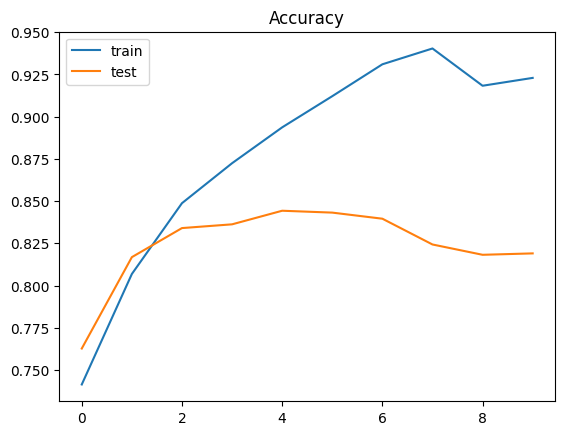

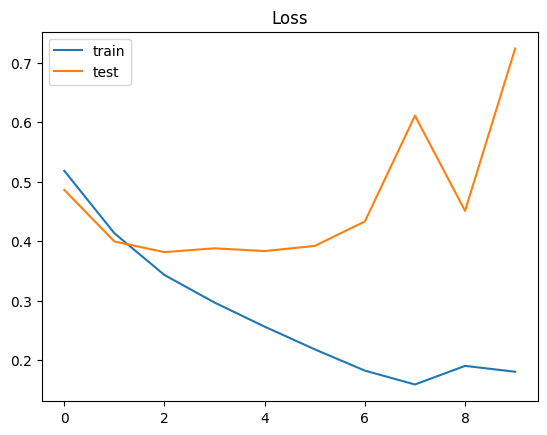

In [61]:
plot_history(history)

Quite overfitted. Let's stop after 4 epochs and introduce dropout layers later

Check performance on all data.

In [62]:
from fhnw.nlp.utils.params import predict_classification
from fhnw.nlp.utils.ploting import report_classification_results

In [71]:
# def predict_classification(params, data, model, preprocessor = None):
#     """Predicts the classes

#     Parameters
#     ----------
#     params: dict
#         The dictionary containing the parameters
#     data: dataframe
#         The data
#     model: model
#         The keras model
#     preprocessor: function
#         Preprocessing transformations like text vectorization (if None this must be part of the model)

#     Returns
#     -------
#     lists/arrays
#         The true labels (ground truth), the predicted labels, and the prediction probabilities
#     """

#     import numpy as np
#     from fhnw.nlp.utils.params import dataframe_to_dataset
#     from fhnw.nlp.utils.params import build_preprocessed_dataset

#     batch_size = 2 * params.get("batch_size", 64)
#     y_column_name = params.get("y_column_name", "label")
#     X_column_name = params.get("X_column_name", "text_clean")
#     prediction_probability_threshold = params.get("prediction_probability_threshold", 0.5)
#     computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
#     label_binarizer = params[computed_objects_column_name]["label_binarizer"]

#     y = data[y_column_name]

#     dataset = dataframe_to_dataset(params, data, False)
#     X = build_preprocessed_dataset(params, dataset, False, preprocessor)

#     y_pred_prob = model.predict(X, batch_size=batch_size)
#     y_pred = label_binarizer.inverse_transform(y_pred_prob, threshold=prediction_probability_threshold)

#     params["labels"] = y
#     params["labels_predicted"] = y_pred
#     params["labels_predicted_probability"] = y_pred_prob

#     return (y, y_pred, y_pred_prob)

In [72]:
y, y_pred, y_pred_prob = predict_classification(params, data, model)

 49/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Set Population: 22516
Accuracy: 0.8509


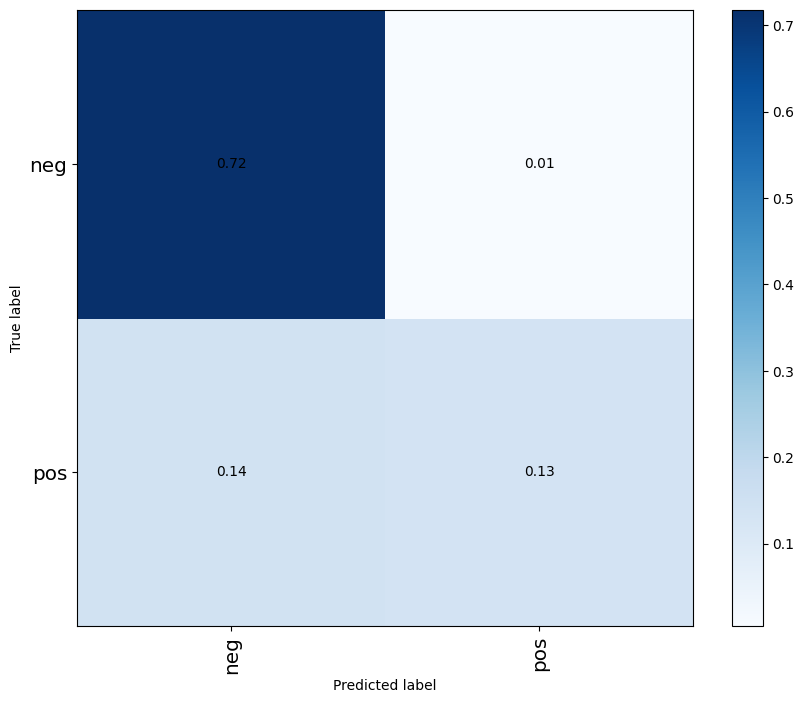

              precision    recall  f1-score   support

         neg       0.83      0.99      0.91     16273
         pos       0.96      0.48      0.64      6243

    accuracy                           0.85     22516
   macro avg       0.90      0.74      0.77     22516
weighted avg       0.87      0.85      0.83     22516

CPU times: user 726 ms, sys: 112 ms, total: 838 ms
Wall time: 835 ms


In [65]:
%%time

report_classification_results(params, data[params.get("y_column_name", "label")].tolist(), y_pred)

Check performance on test data.

In [66]:
y_test, y_test_pred, y_test_pred_prob = predict_classification(params, data_test, model)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Set Population: 4504
Accuracy: 0.8177


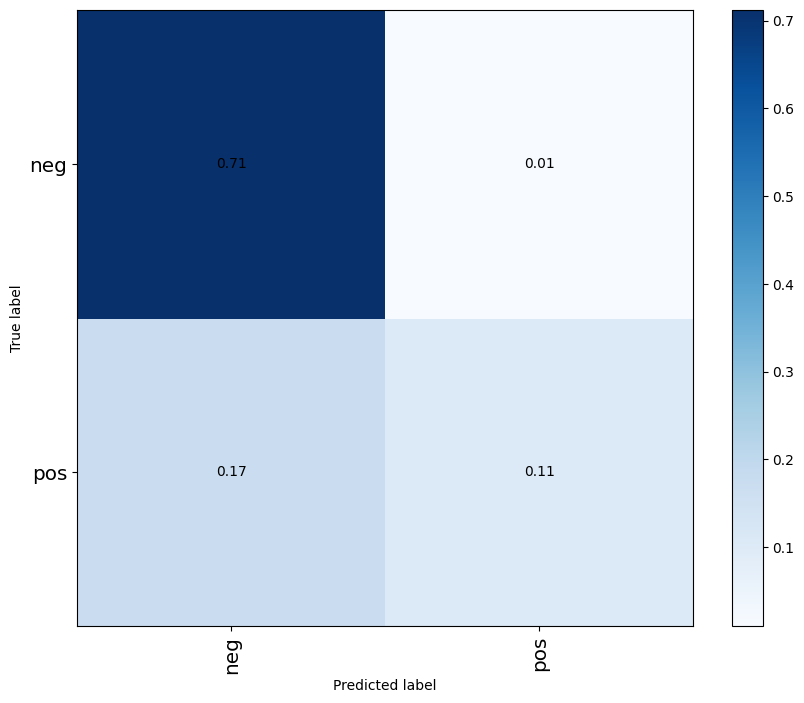

              precision    recall  f1-score   support

         neg       0.81      0.99      0.89      3255
         pos       0.91      0.38      0.54      1249

    accuracy                           0.82      4504
   macro avg       0.86      0.68      0.71      4504
weighted avg       0.83      0.82      0.79      4504

CPU times: user 288 ms, sys: 122 ms, total: 410 ms
Wall time: 279 ms


In [67]:
%%time

report_classification_results(params, data_test[params.get("y_column_name", "label")].tolist(), y_test_pred)

Lets retrain with 4 epochs and check again